In [14]:
import glob
import librosa
import numpy as np
import os
import torch
from hparam import hparam as hp
from speech_embedder_net import SpeechEmbedder
from VAD_segments import VAD_chunk
import scipy.stats as stats
from dvector_create import concat_segs,get_STFTs, align_embeddings
from dvector_vis import visualization
import pandas
from tqdm import tqdm
import shutil

In [15]:
### Initialization
embedder_net = SpeechEmbedder()
embedder_net.load_state_dict(torch.load('/Users/junhengwang/coop/court_data/ckpt/ckpt_epoch_600_batch_id_1324.pth'))
embedder_net.eval()
train_sequence = []
train_cluster_id = []
df = pandas.read_csv("/Users/junhengwang/coop/court_data/court_csvs/02905.csv", delimiter=',')
mp3_file = '/Users/junhengwang/coop/court_data/2900_mp3/2905.mp3'
tmp_dir = './tmp/'
shutil.rmtree(tmp_dir)
os.makedirs(tmp_dir, exist_ok=True)

In [16]:
### Concatenate intervals
concat_df = []
cur_speaker = df.iloc[0]['speaker']
cur_start = df.iloc[0]['start_time']
cur_end = df.iloc[0]['stop_time']
for index, row in df.iterrows():
    if row['speaker'] == cur_speaker:
        cur_end = row['stop_time']
    else:
        concat_df.append({'speaker':cur_speaker, 'start_time':cur_start, 'stop_time':cur_end })
        cur_speaker = row['speaker']
        cur_start = row['start_time']
        cur_end = row['stop_time']
else:
    concat_df.append({'speaker':cur_speaker, 'start_time':cur_start, 'stop_time':cur_end })
print(len(concat_df))

172


In [17]:
### Generate ffmpeg commands
ffm_command_path = tmp_dir + 'ffm_court.txt'
ffm_file = open(ffm_command_path,'w')
#for index, row in df.iterrows():
for index, row in enumerate(concat_df):
    start = float(row['start_time'])
    duration = float(row['stop_time']) - start 
    if duration < 2: continue # skip it if it is too short
    audio_file = tmp_dir + str(index) + '.wav'
    bashCommand = "ffmpeg -ss " + str(round(start,2)) + " -t " + str(round(duration,2)) + " -i " + mp3_file + ' -y -ar 16000 ' +  audio_file
    ffm_file.write(bashCommand + '\n')
ffm_file.close()

In [18]:
### Run ffmpeg in parallel
import subprocess
bashCommand = "parallel -j 50 :::: " + ffm_command_path
process = subprocess.Popen(bashCommand.split(), stdout=subprocess.PIPE)
output, error = process.communicate()
print(output)
print(error)

b''
None


In [19]:
### Create dvector for each audio
import re
def create_dvector():
    audio_files = sorted(glob.glob(tmp_dir + '*.wav'), key=lambda x:int(os.path.basename(x)[:-4]))
    vis_file = open(tmp_dir + "visualization.csv","a+")
    for audio_file in tqdm(audio_files):
        speaker_name = re.sub('[^A-Za-z0-9]+','', concat_df[int(os.path.basename(audio_file)[:-4])]['speaker'])
        try:
            times, segs = VAD_chunk(2, audio_file)
        except:
            print(audio_file + ' is broken')
            continue
        if segs == []:
            print('No voice activity detected in ' + audio_file)
            continue
        concat_seg = concat_segs(times, segs)
        STFT_frames = get_STFTs(concat_seg)
        if not STFT_frames: 
            print('No STFT frames extracted in ' + audio_file)
            continue
        STFT_frames = np.stack(STFT_frames, axis=2)
        STFT_frames = torch.tensor(np.transpose(STFT_frames, axes=(2,1,0)))
        embeddings = embedder_net(STFT_frames) ### slow
        aligned_embeddings = align_embeddings(embeddings.detach().numpy())
        train_sequence.append(aligned_embeddings)
        for embedding in aligned_embeddings:
            train_cluster_id.append(speaker_name)
        ### save npz for visulization, may need to clean csv first
        for index, emb in enumerate(aligned_embeddings):
            save_path = tmp_dir + str(speaker_name) + str(index) + '.npz'
            save_sequence = np.array([emb])
            save_id = np.array([speaker_name] * len(aligned_embeddings))
            np.savez(save_path, train_sequence=save_sequence, train_cluster_id=np.array([speaker_name]))
            vis_file.write(save_path + '\n')
    vis_file.close()
#%prun create_dvector()
create_dvector()

100%|██████████| 139/139 [05:39<00:00,  2.75s/it]


In [20]:
### Saving dvectors
train_sequence = np.concatenate(train_sequence,axis=0)
train_cluster_id = np.asarray(train_cluster_id)
np.save('court_test_sequence',train_sequence)
np.save('court_test_cluster_id',train_cluster_id)
print(train_sequence.shape)
print(train_cluster_id.shape)
print("Speakers:")
print(set(train_cluster_id))

(8672, 256)
(8672,)
Speakers:
{'SoniaSotomayor', 'AnthonyMKennedy', 'JohnGRobertsJr', 'ElenaKagan', 'StephenGBreyer', 'RuthBaderGinsburg', 'BrianHFletcher', 'SethPWaxman', 'SamuelAAlitoJr', 'KathleenMSullivan'}


######## TEST 1 #######
Num of true labels:7
Num of predicted labels:4
Accuracy:0.938


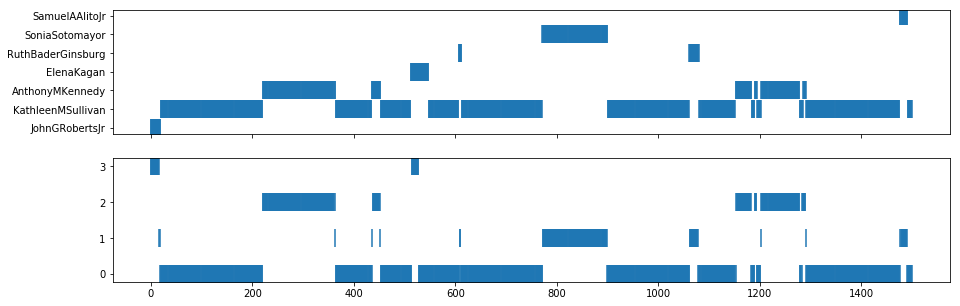

######## TEST 2 #######
Num of true labels:6
Num of predicted labels:4
Accuracy:0.578


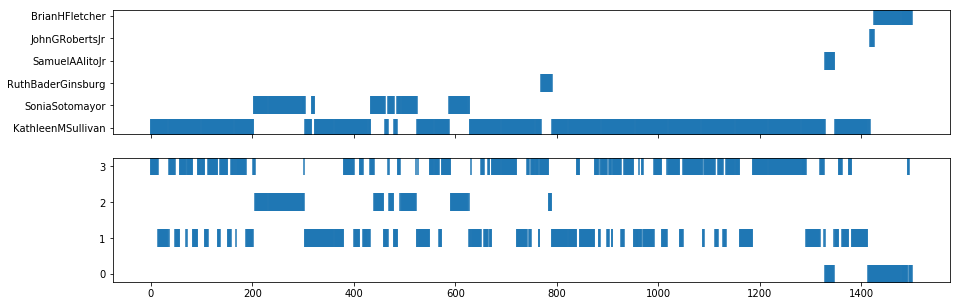

######## TEST 3 #######
Num of true labels:7
Num of predicted labels:4
Accuracy:0.8766666666666667


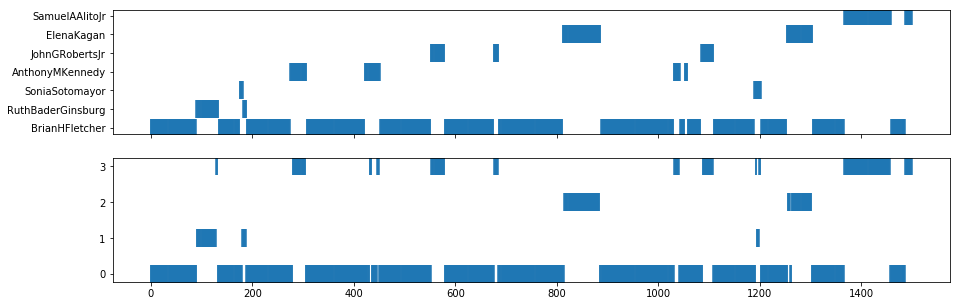

######## TEST 4 #######
Num of true labels:7
Num of predicted labels:4
Accuracy:0.5066666666666667


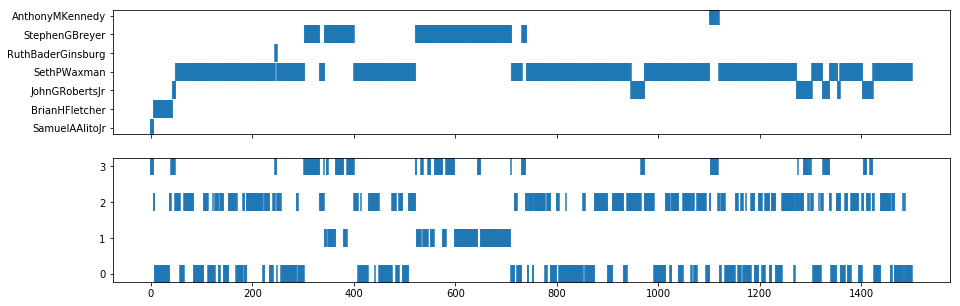

######## TEST 5 #######
Num of true labels:4
Num of predicted labels:4
Accuracy:0.92


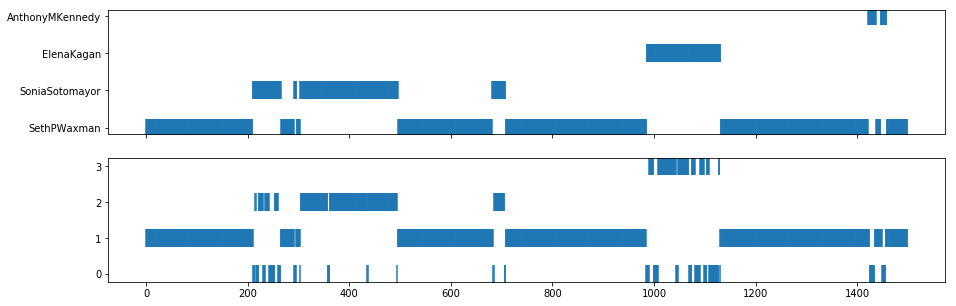

######## TEST 6 #######
Num of true labels:7
Num of predicted labels:4
Accuracy:0.8831058020477816


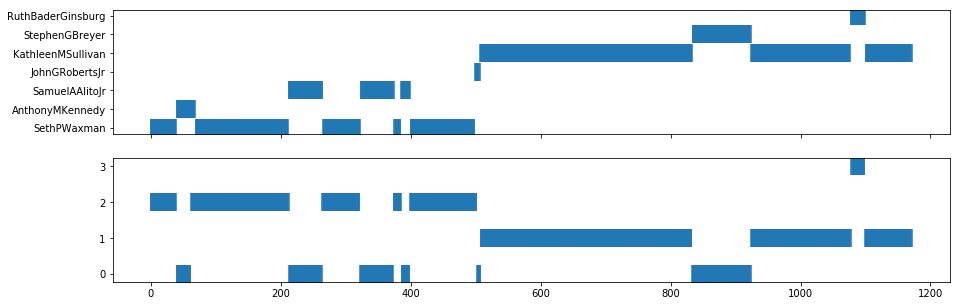

Average accuracy:0.7837398558968526


In [23]:
from spectralcluster import SpectralClusterer
import numpy as np
import uisrnn
import matplotlib.pyplot as plt

test_sequences = np.load('court_test_sequence.npy')
test_cluster_ids = np.load('court_test_cluster_id.npy')
test_size = 1500
test_sequences = np.array([np.array(test_sequences[i:i + test_size]) for i in range(0, len(test_sequences), test_size)])
test_cluster_ids = [list(test_cluster_ids[i:i + test_size]) for i in range(0,len(test_cluster_ids),test_size)]
index = 1

### MULTI
from multiprocessing import Pool
def spectral_parallel(sequence):
    clusterer = SpectralClusterer(min_clusters=4,max_clusters=20,p_percentile=0.92,gaussian_blur_sigma=2.3, metric='spherical')
    labels = clusterer.predict(sequence)
    return labels
NUM_PROCESSES = 3
pool = Pool(NUM_PROCESSES)
results = pool.map(spectral_parallel, test_sequences)
index = 1
accuracy_lst = []
for true_labels, predicted_labels in zip(test_cluster_ids, results):
    print("######## TEST " + str(index) + " #######")
    print("Num of true labels:" + str(len(set(true_labels))))
    print("Num of predicted labels:" + str(len(set(predicted_labels))))
    accuracy = uisrnn.compute_sequence_match_accuracy(list(true_labels), list(predicted_labels))
    accuracy_lst.append(accuracy)
    print("Accuracy:" + str(accuracy))
    index += 1
    f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(15, 5))
    ax1.scatter(range(len(true_labels)), true_labels, s=300, marker='|')
    ax2.scatter(range(len(predicted_labels)), predicted_labels, s=300, marker='|')
    plt.show()
print('Average accuracy:' + str(np.mean(accuracy_lst)))


  3%|▎         | 95/3000 [00:00<00:03, 946.89it/s]

./tmp/visualization.csv


100%|██████████| 3000/3000 [00:03<00:00, 911.12it/s]


==> Finish loading
==> Finish pca
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3000 samples in 0.026s...
[t-SNE] Computed neighbors for 3000 samples in 4.257s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3000
[t-SNE] Computed conditional probabilities for sample 2000 / 3000
[t-SNE] Computed conditional probabilities for sample 3000 / 3000
[t-SNE] Mean sigma: 0.005706
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.759720
[t-SNE] KL divergence after 300 iterations: 1.423297
<class 'numpy.ndarray'>


/usr/local/lib/python3.7/site-packages/seaborn/regression.py:546: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


==> Finish tsne


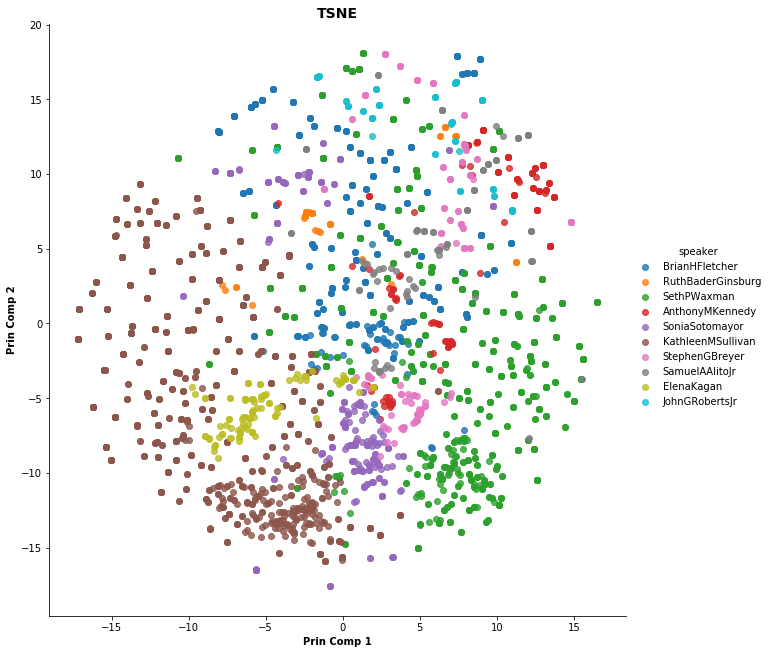

In [22]:
tmp_dir = './tmp/'
visualization(tmp_dir + 'visualization.csv', 3000)

Observation from spectral:

1. Could not predicted the number of speakers correctly mostly because some speakers have too few dvectors. 

Observation from visualization:

1. There is a big region of scatter, possibly due to noise

2. The embedding model seems to be not robust enough.

In [6]:
from multiprocessing import Pool
from spectralcluster import SpectralClusterer
import numpy as np
import uisrnn
import matplotlib.pyplot as plt
test_sequences = np.load('court_test_sequence.npy')
test_cluster_ids = np.load('court_test_cluster_id.npy')
test_size = 1500
test_sequences = np.array([np.array(test_sequences[i:i + test_size]) for i in range(0, len(test_sequences), test_size)])
test_cluster_ids = [list(test_cluster_ids[i:i + test_size]) for i in range(0,len(test_cluster_ids),test_size)]
index = 1
def spectral_para(sequence):
    global gaussian_blur_sigma
    clusterer = SpectralClusterer(min_clusters=3,max_clusters=20,p_percentile=0.92,gaussian_blur_sigma=gaussian_blur_sigma,cosine=False)
    labels = clusterer.predict(sequence)
    return labels
gaussian_blur_sigma = 2.4
for num in range(5):
    gaussian_blur_sigma = 2.4 + 0.1*num
    print(gaussian_blur_sigma)
    NUM_PROCESSES = 3
    pool = Pool(NUM_PROCESSES)
    results = pool.map(spectral_para, test_sequences)
    index = 1
    accuracy_lst = []
    for true_labels, predicted_labels in zip(test_cluster_ids, results):
        accuracy = uisrnn.compute_sequence_match_accuracy(list(true_labels), list(predicted_labels))
        print(accuracy)
        accuracy_lst.append(accuracy)
        index += 1
        #f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(15, 5))
        #ax1.scatter(range(len(true_labels)), true_labels, s=300, marker='|')
        #ax2.scatter(range(len(predicted_labels)), predicted_labels, s=300, marker='|')
        #plt.show()
    print('Average accuracy:' + str(np.mean(accuracy_lst)))

2.4
0.8493333333333334
0.5906666666666667
0.6333333333333333
0.7966666666666666
0.834
0.8492871690427699
Average accuracy:0.7588811948404617
2.5
0.8486666666666667
0.5873333333333334
0.6326666666666667
0.796
0.8346666666666667
0.8492871690427699
Average accuracy:0.7581034170626838
2.6
0.8506666666666667
0.5886666666666667
0.6326666666666667
0.7946666666666666
0.8326666666666667
0.8533604887983707
Average accuracy:0.7587823036886174
2.7
0.7033333333333334
0.588
0.6313333333333333
0.794
0.8306666666666667
0.8513238289205702
Average accuracy:0.7331095270423172
2.8
0.7046666666666667
0.59
0.6313333333333333
0.792
0.828
0.8513238289205702
Average accuracy:0.7328873048200949


In [ ]:
'''

#SPECTRAL SINGLE PRO
accuracy_lst = []
for sequence, cluster_ids in zip(test_sequences, test_cluster_ids):
    print("######## TEST " + str(index) + " #######")
    print("Num of true labels:" + str(len(set(cluster_ids))))
    clusterer = SpectralClusterer(min_clusters=3,max_clusters=20,p_percentile=0.92,gaussian_blur_sigma=2)
    labels = clusterer.predict(sequence)
    print("Num of predicted labels:" + str(len(set(labels))))
    accuracy = uisrnn.compute_sequence_match_accuracy(list(cluster_ids), list(labels))
    accuracy_lst.append(accuracy)
    print("Accuracy:" + str(accuracy))
    index += 1
    f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(15, 5))
    ax1.scatter(range(len(cluster_ids)), cluster_ids, s=300, marker='|')
    ax2.scatter(range(len(labels)), labels, s=300, marker='|')
    plt.show()
print('Average accuracy:' + str(np.mean(accuracy_lst)))
'''